<a href="https://colab.research.google.com/github/jmannin/Overfeat/blob/main/DL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from keras.layers import Input, Dense, Concatenate, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Class Stype

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/Year 4/Deep Learning/Final Project"

In [ ]:
trainDataPath = "/content/drive/MyDrive/Year 4/Deep Learning/Final Project/train.npz"
validDataPath = "/content/drive/MyDrive/Year 4/Deep Learning/Final Project/valid.npz"

In [ ]:
trainData = np.load(trainDataPath)
#validData = np.load(validDataPath)

In [ ]:
train_inputs = trainData['inputs']
#train_classifications = 0 #trainData['classifications']
train_bboxes = trainData['bboxes']

In [ ]:
def accuracy_fnc(labels, logits):

    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [ ]:
class Overfeat(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.forward = tf.keras.Sequential([layers.Conv2D(filters=32, kernel_size=11, strides=4, activation='relu'),
                                           layers.MaxPooling2D(pool_size=2, strides=2),
                                           layers.Conv2D(filters=64, kernel_size=5, strides=1, activation='relu'),
                                           layers.MaxPooling2D(pool_size=2, strides=2),
                                           layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
                                           layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
                                           layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
                                           layers.MaxPooling2D(pool_size=2, strides=2),
                                           ], name = 'Overfeat')

    def call(self, inputs, training = False):
        return self.forward(inputs)

In [ ]:
class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.forward = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(units=385, activation='relu'),
                                            layers.Dropout(0.5),
                                            layers.Dense(units=512, activation='relu'),
                                            layers.Dropout(0.5),
                                            layers.Dense(units=self.num_classes, activation='softmax')
                                            ], name = 'Classifier')
    def call(self, inputs, training = False):

      return self.forward(inputs)


In [ ]:
def train_classification(overfeat, classifier, train_inputs, train_labels, optimizer, batch_size, loss_fnc, acc_fnc, epochs = 10):
    loss_list = []

    for e in range(epochs):
        indices = np.arange(train_inputs.shape[0])
        indices = tf.random.shuffle(indices)

        inputs = tf.gather(train_inputs, indices)
        labels = tf.gather(train_labels, indices)

        batch_num = inputs.shape[0] // batch_size
        for b, b1 in enumerate(range(batch_size, inputs.shape[0] + 1, batch_size)):
            b0 = b1 - batch_size
            batch_inputs = inputs[b0:b1, :, :, :]
            batch_labels = labels[b0:b1, :]

            batch_inputs = tf.image.random_flip_left_right(batch_inputs)

            with tf.GradientTape() as tape:
                overfeat_out = overfeat(batch_inputs)

                logits = classifier(overfeat_out)

                logits = classifier(overfeat_out)

                loss = loss_fnc(batch_labels, logits)


            all_weights = classifier.trainable_weights + overfeat.trainable_weights
            gradients = tape.gradient(loss, all_weights)
            optimizer.apply_gradients(zip( gradients, all_weights ))

        overfeat_out = overfeat(train_inputs)
        logits = classifier(overfeat_out)

        loss = loss_fnc(train_labels, logits)
        accuracy = acc_fnc(train_labels, logits)
        print(f"epoch {e}: train_loss = {loss}, train_acc = {accuracy}")

        loss_list.append(loss)

In [ ]:
overfeat = tf.keras.models.load_model(dir_path + "/overfeat3") #Overfeat()
classifier = tf.keras.models.load_model(dir_path + "/classifier3")  #Classifier(3)

In [ ]:
train_inputs = tf.convert_to_tensor(train_inputs, dtype = float) #tf.convert_to_tensor(imagesTrain, dtype=float)
train_classifications = tf.convert_to_tensor(train_classifications, dtype = float) #tf.convert_to_tensor( classificationTrain, dtype = float)

In [ ]:
batch_size = 128
loss_fnc = tf.keras.losses.CategoricalCrossentropy()
acc_fnc = accuracy_fnc
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [ ]:
train_classification(overfeat, classifier, train_inputs, train_classifications, optimizer, batch_size, loss_fnc, acc_fnc)

epoch 0: train_loss = 0.22686532139778137, train_acc = 0.9240707159042358
epoch 1: train_loss = 0.22113963961601257, train_acc = 0.9351767897605896
epoch 2: train_loss = 0.17967988550662994, train_acc = 0.9424297213554382
epoch 3: train_loss = 0.17919743061065674, train_acc = 0.9388032555580139
epoch 4: train_loss = 0.16165848076343536, train_acc = 0.9451496005058289
epoch 5: train_loss = 0.16316606104373932, train_acc = 0.9433363676071167
epoch 6: train_loss = 0.1338234692811966, train_acc = 0.9524025321006775
epoch 7: train_loss = 0.1370449811220169, train_acc = 0.9576156139373779
epoch 8: train_loss = 0.14393958449363708, train_acc = 0.9487760663032532
epoch 9: train_loss = 0.15920068323612213, train_acc = 0.949002742767334


In [ ]:
overfeat.save(dir_path + "/overfeat3")

In [ ]:
classifier.save(dir_path + "/classifier3")

## Evaluation

In [ ]:
validData = np.load(validDataPath)

In [ ]:
valid_inputs = validData['inputs']
valid_classifications = validData['classifications']

In [ ]:
overfeat_out = overfeat(train_inputs)
logits = classifier(overfeat_out)

loss = loss_fnc(train_classifications, logits)
accuracy = acc_fnc(train_classifications, logits)

In [ ]:
print(accuracy)

tf.Tensor(0.94900274, shape=(), dtype=float32)


## Training Regression

In [ ]:
class Regression(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.forward = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(units=770, activation='relu'),
                                            layers.Dense(units=1024, activation='relu'),
                                            layers.Dense(units = 4)
                                            ], name = 'Regressor')


    def call(self, inputs, training=False):

        return self.forward(inputs)

In [ ]:
def train_regression(overfeat, regression, train_inputs, train_bboxes, optimizer, batch_size, loss_fnc, epochs = 10):

    # Set the base model to not trainable

    loss_list = []

    for e in range(epochs):
        indices = np.arange(train_inputs.shape[0])
        indices = tf.random.shuffle(indices)

        inputs = tf.gather(train_inputs, indices)
        labels = tf.gather(train_bboxes, indices)

        batch_num = inputs.shape[0] // batch_size
        for b, b1 in enumerate(range(batch_size, inputs.shape[0] + 1, batch_size)):
            b0 = b1 - batch_size
            batch_inputs = inputs[b0:b1, :, :, :]
            batch_labels = labels[b0:b1, :]

            with tf.GradientTape() as tape:
                overfeat_out = overfeat(batch_inputs)
                logits = regression(overfeat_out)

                loss = loss_fnc(batch_labels, logits)

            all_weights = regression.trainable_weights

            gradients = tape.gradient(loss, all_weights)
            optimizer.apply_gradients(zip( gradients, all_weights ))

        overfeat_out = overfeat(train_inputs)
        logits = regression(overfeat_out)

        loss = loss_fnc(train_bboxes, logits)

        print(f"epoch {e}: train_loss = {loss}")

        loss_list.append(loss)

In [ ]:
batch_size = 128
loss_fnc = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [ ]:
overfeat = tf.keras.models.load_model(dir_path + "/overfeat3")
regression = Regression()

train_inputs = tf.convert_to_tensor(train_inputs, dtype = float)
train_bboxes = tf.convert_to_tensor(train_bboxes, dtype = float)

In [ ]:
train_regression(overfeat, regression, train_inputs, train_bboxes, optimizer, batch_size, loss_fnc, epochs = 20)

epoch 0: train_loss = 424.67291259765625
epoch 1: train_loss = 424.8111877441406
epoch 2: train_loss = 420.08251953125
epoch 3: train_loss = 408.17388916015625
epoch 4: train_loss = 413.51324462890625
epoch 5: train_loss = 403.5064697265625
epoch 6: train_loss = 399.8035888671875
epoch 7: train_loss = 397.07012939453125
epoch 8: train_loss = 399.3522644042969
epoch 9: train_loss = 419.1403503417969
epoch 10: train_loss = 389.37518310546875
epoch 11: train_loss = 387.7330322265625
epoch 12: train_loss = 386.2437438964844
epoch 13: train_loss = 382.9404602050781
epoch 14: train_loss = 383.9167785644531
epoch 15: train_loss = 367.07110595703125
epoch 16: train_loss = 364.2298278808594
epoch 17: train_loss = 362.7608642578125
epoch 18: train_loss = 361.27398681640625
epoch 19: train_loss = 353.4579772949219


In [ ]:
regression.save(dir_path + "/regressor40epochs")

## Validate Regressor

In [ ]:
## Garbage collection
train_inputs = 0
train_bboxes = 0

In [ ]:
validData = np.load(validDataPath)

In [ ]:
valid_inputs = validData['inputs']
valid_bboxes = validData['bboxes']

In [ ]:
valid_inputs = tf.convert_to_tensor(valid_inputs, dtype = float)
valid_bboxes = tf.convert_to_tensor(valid_bboxes, dtype = float)

In [ ]:
overfeat_out = overfeat(valid_inputs)
logits = regression(overfeat_out)

loss = loss_fnc(valid_bboxes, logits)
print(loss)

tf.Tensor(444.44836, shape=(), dtype=float32)


In [ ]:
valid_inputs = valid_inputs.numpy()
valid_bboxes = valid_bboxes.numpy()
bboxes_predicted = logits.numpy()

In [ ]:
valid_bboxes.shape

(282, 4)

<Figure size 1920x1440 with 0 Axes>

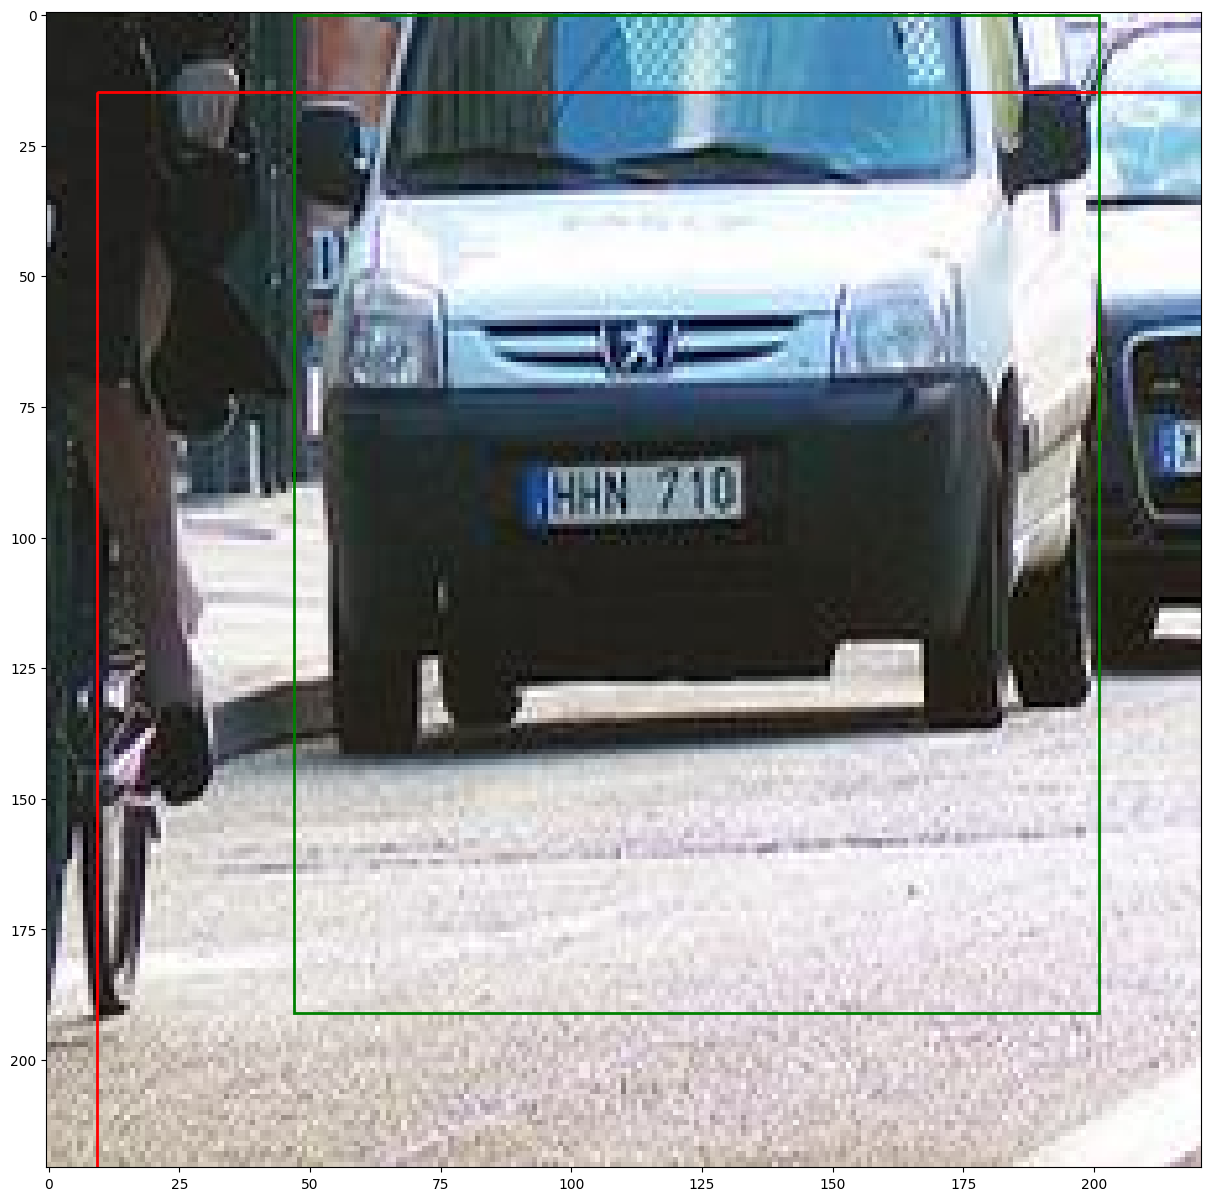

In [ ]:
img_num = 23

img = valid_inputs[img_num, :, :, :]
bbox_predicted = bboxes_predicted[img_num, :]
bbox_valid = valid_bboxes[img_num, :]

plt.figure(dpi = 300)

fig, ax = plt.subplots(1, figsize=(15, 15))

ax.imshow(img)

xy_predicted = (bbox_predicted[0], bbox_predicted[1])
width_predicted = bbox_predicted[2]
height_predicted = bbox_predicted[3]
rect_predicted = patches.Rectangle(xy_predicted, width_predicted, height_predicted, linewidth=2, \
                         fill = False, color = 'red')

xy_valid = (bbox_valid[0], bbox_valid[1])
width_valid = bbox_valid[2]
height_valid = bbox_valid[3]
rect_valid = patches.Rectangle(xy_valid, width_valid, height_valid, linewidth=2, \
                         fill = False, color = 'green')



ax.add_patch(rect_predicted)
ax.add_patch(rect_valid)

plt.show()

In [ ]:
# Calculate intersection coordinates
x1_intersection = max(bbox_predicted[0], bbox_valid[0])
y1_intersection = max(bbox_predicted[1], bbox_valid[1])
x2_intersection = min(bbox_predicted[0] + bbox_predicted[2], bbox_valid[0] + bbox_valid[2])
y2_intersection = min(bbox_predicted[1] + bbox_predicted[3], bbox_valid[1] + bbox_valid[3])

# Calculate intersection area
intersection_area = max(0, x2_intersection - x1_intersection) * max(0, y2_intersection - y1_intersection)

# Calculate union area
bbox_predicted_area = bbox_predicted[2] * bbox_predicted[3]
bbox_valid_area = bbox_valid[2] * bbox_valid[3]
union_area = bbox_predicted_area + bbox_valid_area - intersection_area

# Calculate IoU
IoU = intersection_area / union_area

print("IoU:", IoU)

Because we will be implementing three different tasks, there should be three different loss functions that can be composited.
**Classification**: standard MSE Loss should suffice.
**Localization**: the predicted bounding box must match the ground truth by at least 50%. The Loss function to exectute this is called PASCAL criterion for bounding box overlap of union over intersection. In the Combining Predictions section, the paper calls for a match_score function to determine the intersection area of box, and then a box_merge function to average the coordinates of the bounding box.

In [ ]:
def match_score(box1, box2):
    '''
    Purpose: computes the match_score for the bounding boxes. This is the sum of distances between the centers of the two boxes and the intersection.
    args: box1 and box2 are four-element tuples (x1, y1, x2, y2).
    return: match_score (float): the match score between the two boxes

    '''
    #take maximum corner of the upper edges of intersection region
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    #take minimum corner of the lower edges of intersection region
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    #calculate intersection area (hence multiplication) of the two bounding boxes. If no intersection, then 0
    #the +1 ensures that the intersection area is positive if chosen
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    #centers of boxes is average of x and y coords
    box1_center = np.array([(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2])
    box2_center = np.array([(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2])
    #find the euclidean distance of these center points
    center_distance = np.linalg.norm(box1_center - box2_center)
    #match_score is sum of distance and interestion
    match_score = center_distance + intersection_area
    return match_score

In [ ]:
def box_merge(boxes):
    """
    Purpose: computes the average of the bounding boxes' coordinates.
    Args: a list of bounding boxes, each represented as a tuple (xmin, ymin, xmax, ymax)
    Returns: merged_box (tuple, a merged bounding box represented as a tuple (xmin, ymin, xmax, ymax)
    """
    #basically average each coordinate in all the boxes
    xmin = np.mean([box[0] for box in boxes])
    ymin = np.mean([box[1] for box in boxes])
    xmax = np.mean([box[2] for box in boxes])
    ymax = np.mean([box[3] for box in boxes])
    merged_box = (xmin, ymin, xmax, ymax)
    return merged_box

In [ ]:
def combine_predictions(predictions, threshold=0.5):
    """
    Combines the individual predictions of the object detection model to obtain the final prediction.

    Args:
    - predictions (dict): A dictionary with the following keys:
                          - "class_scores": An array containing the detection class scores
                          - "bounding_boxes": An array containing the predicted bounding boxes
    - threshold (float): The threshold for the match score below which bounding boxes are merged

    Returns:
    - merged_boxes (dict): A dictionary with the following keys:
                           - "class_scores": An array containing the detection class scores for each object
                           - "bounding_boxes": An array containing the merged bounding boxes for each object
    """

    class_scores = predictions["class_scores"].numpy()
    bounding_boxes = predictions["bounding_boxes"].numpy()

    merged_class_scores = []
    merged_bounding_boxes = []

    # Step 1: Gather the set of bounding boxes predicted by the regressor network for each class
    for c in range(class_scores.shape[1]):
        indices = np.where(class_scores[:, c] >= threshold)[0]

        # This makes sure that our number of class scores is the same as the number of bounding boxes
        indices = indices[indices < len(bounding_boxes)]

        if len(indices) == 0:
            continue

        boxes = bounding_boxes[indices]
        class_scores_c = class_scores[indices, c]

        # Remove duplicate boxes and update corresponding class scores
        unique_boxes, unique_indices = np.unique(boxes, axis=0, return_index=True)
        unique_class_scores_c = class_scores_c[unique_indices]

        # Replace boxes and class_scores_c with unique values
        boxes = unique_boxes
        class_scores_c = unique_class_scores_c


        # Step 2: Merge the overlapping bounding boxes using a greedy strategy
        while len(boxes) > 1:
            match_scores = np.zeros((len(boxes), len(boxes)))
            for i in range(len(boxes)):
                for j in range(i+1, len(boxes)):
                    match_scores[i,j] = match_score(boxes[i], boxes[j])

            highest_match_score = np.max(match_scores)
            i, j = np.where(match_scores == highest_match_score)
            i, j = i[0], j[0]  # Extract the first index values
            #print("Match scores matrix:", match_scores)
            #print("Lowest match score:", match_scores[i, j])
            #print("Box i:", boxes[i])
            #print("Box j:", boxes[j])


            if match_scores[i,j] < threshold:
                break

            new_box = box_merge([boxes[i], boxes[j]])
            #print("Combined box:", new_box)

            new_score = class_scores_c[i] + class_scores_c[j]

            boxes = np.concatenate([boxes[:i], boxes[i+1:j], boxes[j+1:], [new_box]])
            class_scores_c = np.concatenate([class_scores_c[:i], class_scores_c[i+1:j], class_scores_c[j+1:], [new_score]])
            #print(len(boxes))
        # Step 3: Select the merged bounding boxes with the highest class scores
        best_boxes_indices = np.argsort(-class_scores_c)
        merged_class_scores.append(class_scores_c[best_boxes_indices])
        merged_bounding_boxes.append(boxes[best_boxes_indices])


    merged_boxes = {"class_scores": np.concatenate(merged_class_scores), "bounding_boxes": np.concatenate(merged_bounding_boxes)}
    print("Shape of merged bounding boxes:", merged_boxes["bounding_boxes"].shape)
    print("example of Merged bounding boxes:", merged_boxes["bounding_boxes"][0])

    return merged_boxes


Model Outline

In [ ]:
def create_fast_model(input_shape=(256, 256, 3), num_classes=1000):
    # Layers 1-5
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=5, strides=1, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Layers 6-8 as a separate modular model
    def create_classifier(input_shape):
        inputs = layers.Input(shape=input_shape)
        x = layers.Flatten()(inputs)
        x = layers.Dense(units=3072, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(units=4096, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(units=num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs)
        return model

    # Create classifier model with fixed input shape
    classifier_input_shape = x.shape[1:]
    classifier = create_classifier(classifier_input_shape)

    # Connect classifier to base model
    x = classifier(x)

    # Create final model
    model = models.Model(inputs=inputs, outputs=x)

    return model


Here is my go at making the sliding window that had modular components still

In [ ]:
def create_sliding_window_model(input_shape=(221, 221, 3), num_classes=1000, scales=[1.0, 0.875, 0.75, 0.66, 0.5, 0.33]):
    # Base model (layers 1-5)
    def create_base_model(input_layer):
        x = Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='valid')(input_layer)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        x = Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
        return x

    # Classifier model (layers 6-8)
    def create_classifier(input_layer):
        y = Flatten()(input_layer)
        y = Dense(3072, activation='relu')(y)
        y = Dense(4096, activation='relu')(y)
        y = Dense(num_classes, activation='softmax')(y)
        return y

    # Input layer
    input_layer = Input(shape=input_shape)

    # Create base model
    x = create_base_model(input_layer)

    # Create classifier model
    classifier_output = create_classifier(x)

    # Sliding window output
    sliding_window_output = []

    ##Note the 6 scaling components used
    for scale in scales:
        # Rescale input
        rescaled_input = Input(shape=(int(input_shape[0] * scale), int(input_shape[1] * scale), input_shape[2]))

        # Create base model for the rescaled input
        rescaled_x = create_base_model(rescaled_input)

        # Create pooled maps
        pooled_maps = []
        for x_offset in range(3):
            for y_offset in range(3):
                pooled_map = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid')(rescaled_x[:, x_offset::3, y_offset::3, :])
                pooled_maps.append(pooled_map)

        # Concatenate pooled maps
        pooled_maps = Concatenate()(pooled_maps)

        # Apply classifier model to pooled_maps
        output_map = create_classifier(pooled_maps)

        # Append output_map to sliding_window_output
        sliding_window_output.append(output_map)

    # Concatenate output maps from different scales
    y = Concatenate()(sliding_window_output)

    # Create the sliding window model
    model = Model(inputs=input_layer, outputs=y)

    return model

Here is regression component that we then train with L2 loss between predicted and true bounding box coordinates and integrate with sliding window model. During prediction, we are supposed to run both networks simultaneously and combine their results to generate the final object detections. I chose Single Class Regression (rather than per class regression) so we only need to look at one bounding box when evaluating our model. It also performed the best according to the paper, so let's try it.

In [ ]:

def create_regression_network(input_shape, num_classes=1000):
    input_layer = Input(shape=input_shape)
    x = Flatten()(input_layer)
    x = Dense(4096, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)

    # Create class-specific output layers
    #if i want single class regressiong then use:
    #must be 4 if we are using single class
    output = Dense(4, activation='linear')(x)
    #if i want a PCR; per class regression. This will require other edits in handling our bounding box
    #output_layers = [Dense(4, activation='linear', name=f'bbox_{i}')(x) for i in range(num_classes)]

    # Concatenate output layers
    #output = Concatenate()(output_layers)

    model = Model(inputs=input_layer, outputs=output)

    return model

How i am trying to evaluate the model.

In [ ]:
def iou(box1, box2):
    xmin1, ymin1, xmax1, ymax1 = box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]
    xmin2, ymin2, xmax2, ymax2 = box2[0], box2[1], box2[0] + box2[2], box2[1] + box2[3]

    x1 = max(xmin1, xmin2)
    y1 = max(ymin1, ymin2)
    x2 = min(xmax1, xmax2)
    y2 = min(ymax1, ymax2)

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    union_area = box1_area + box2_area - intersection_area
    return intersection_area / union_area


def evaluate_model(overfeat, classifier, regression, valid_inputs, valid_classifications, valid_bboxes, threshold=0.5):
    overfeat_out = overfeat(valid_inputs).numpy()
    y_pred_classification = classifier(overfeat_out).numpy()
    y_pred_regression = regression(overfeat_out).numpy()


    n_classes = y_pred_classification.shape[1]
    y_pred_classification = tf.reshape(y_pred_classification, (-1, n_classes))



    predictions = {
        "class_scores": y_pred_classification,
        "bounding_boxes": tf.reshape(y_pred_regression, (-1, 4))
    }
    print('check evaluate model, classification shape ', y_pred_classification)
    print('check evaluate model, bbox shape ', y_pred_regression)
    #print("Shape of 'class_scores':", predictions["class_scores"].shape)
    #print("Shape of 'bounding_boxes':", predictions["bounding_boxes"].shape)

    #print("\nExample 'class_scores' values:")
    #print(predictions["class_scores"][:5])  # Print the first 5 class scores

    #print("\nExample 'bounding_boxes' values:")
    #print(predictions["bounding_boxes"][:5])  # Print the first 5 bounding boxes


    merged_boxes = combine_predictions(predictions)
    print('made it out of comb')
    truepos = 0
    falsepos = 0
    falseneg = 0



    for gt_boxes, pred_boxes in zip(valid_bboxes, merged_boxes["bounding_boxes"]):
        matched_gt_boxes = set()

        for i, gt_box in enumerate(gt_boxes):
            if i in matched_gt_boxes:
                continue
            print("pred_box:", pred_boxes, "gt_box:", gt_box)
            if iou(pred_boxes, gt_box) >= threshold:
                matched_gt_boxes.add(i)
                truepos += 1
                break
        else:
            falsepos += 1

        falseneg += len(gt_boxes) - len(matched_gt_boxes)

    return truepos, falsepos, falseneg



\Trying to put it all together, this may need a great deal of editing. The regression format may be an issue. Code run, but our training loss is weak and that seems to transpire in the evaluation of the model.

In [ ]:

import tensorflow as tf
import numpy as np
from keras.layers import Input, Dense, Concatenate, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from keras.models import Model
from keras import layers, models
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, CategoricalCrossentropy
from model import evaluate_model


def accuracy_fnc(labels, logits):
    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

class Overfeat(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.forward = tf.keras.Sequential([layers.Conv2D(filters=32, kernel_size=11, strides=4, activation='relu'),
                                           layers.MaxPooling2D(pool_size=2, strides=2),
                                           layers.Conv2D(filters=64, kernel_size=5, strides=1, activation='relu'),
                                           layers.MaxPooling2D(pool_size=2, strides=2),
                                           layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
                                           layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
                                           layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
                                           layers.MaxPooling2D(pool_size=2, strides=2),
                                           ], name = 'Overfeat')

    def call(self, inputs, training = False):
        return self.forward(inputs)

class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.forward = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(units=385, activation='relu'),
                                            layers.Dropout(0.5),
                                            layers.Dense(units=512, activation='relu'),
                                            layers.Dropout(0.5),
                                            layers.Dense(units=self.num_classes, activation='softmax')
                                            ], name = 'Classifier')
    def call(self, inputs, training = False):
      y = self.sliding_window(inputs)

      return y

    def sliding_window(self, inputs):
        # Sliding window output
        sliding_window_output = []

        # Pad inputs to ensure consistent shape
        padded_inputs = ZeroPadding2D(padding=((0, 1), (0, 1)))(inputs)

        # Create pooled maps
        pooled_maps = []
        for x_offset in range(2):
            for y_offset in range(2):
                pooled_map = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(padded_inputs[:, x_offset::2, y_offset::2, :])
                #print("Pooled map shape:", pooled_map.shape)
                pooled_maps.append(pooled_map)

        #print(pooled_maps)
        # Concatenate pooled maps
        pooled_maps = Concatenate()(pooled_maps)

        # Apply classifier model to pooled_maps
        output_map = self.forward(pooled_maps)

        # Append output_map to sliding_window_output
        sliding_window_output.append(output_map)

        # Concatenate output maps from different scales
        y = Concatenate()(sliding_window_output)
        return y

class Regression(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(4096, activation='relu')
        self.dense2 = layers.Dense(1024, activation='relu')

        # Create class-specific output layers
        self.output_layers = [layers.Dense(4, activation='linear', name=f'bbox_{i}') for i in range(num_classes)]

    def call(self, inputs, training=False):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)

        # Apply the class-specific output layers
        outputs = [output_layer(x) for output_layer in self.output_layers]

        # Concatenate output layers
        y = layers.Concatenate()(outputs)

        return y

def rescale_outputs(outputs, scales):
    rescaled_outputs = []
    for scale in scales:
        rescaled_output = tf.image.resize(outputs, (int(outputs.shape[1] * scale), int(outputs.shape[2] * scale)))
        rescaled_outputs.append(rescaled_output)
    return rescaled_outputs

def train_classification(overfeat, classifier, train_inputs, train_labels, optimizer, batch_size, loss_fnc, acc_fnc, epochs = 5):
    loss_list = []

    for e in range(epochs):
        indices = np.arange(train_inputs.shape[0])
        indices = tf.random.shuffle(indices)

        inputs = tf.gather(train_inputs, indices)
        labels = tf.gather(train_labels, indices)

        batch_num = inputs.shape[0] // batch_size
        for b, b1 in enumerate(range(batch_size, inputs.shape[0] + 1, batch_size)):
            b0 = b1 - batch_size
            batch_inputs = inputs[b0:b1, :, :, :]
            batch_labels = labels[b0:b1, :]

            batch_inputs = tf.image.random_flip_left_right(batch_inputs)

            with tf.GradientTape() as tape:
                overfeat_out = overfeat(batch_inputs)

                    # Rescale the outputs of the base model
                #rescaled_outputs = rescale_outputs(overfeat_out, scales=[1.0, 0.875, 0.75, 0.66, 0.5, 0.33])

                #logits_list = []
                #for rescaled_output in rescaled_outputs:
                logits = classifier(overfeat_out)
                   # logits_list.append(logits)

                # Concatenate output maps from different scales
                #logits_concatenated = tf.concat(logits_list, axis=1)

                #logits = classifier(overfeat_out)

                #logits = classifier(overfeat_out)

                loss = loss_fnc(batch_labels, logits)


            all_weights = classifier.trainable_weights + overfeat.trainable_weights
            gradients = tape.gradient(loss, all_weights)
            optimizer.apply_gradients(zip( gradients, all_weights ))

        overfeat_out = overfeat(train_inputs)
        logits = classifier(overfeat_out)

        loss = loss_fnc(train_labels, logits)
        accuracy = acc_fnc(train_labels, logits)
        print(f"epoch {e}: train_loss = {loss}, train_acc = {accuracy}")

        loss_list.append(loss)

def train_regression(overfeat, regression, train_inputs, train_bboxes_with_classes, optimizer, batch_size, loss_fnc, acc_fnc, epochs = 5):

    # Set the base model to not trainable
    overfeat.trainable = False

    loss_list = []

    for e in range(epochs):
        indices = np.arange(train_inputs.shape[0])
        indices = tf.random.shuffle(indices)

        inputs = tf.gather(train_inputs, indices)
        labels = tf.gather(train_bboxes_with_classes, indices)

        batch_num = inputs.shape[0] // batch_size
        for b, b1 in enumerate(range(batch_size, inputs.shape[0] + 1, batch_size)):
            b0 = b1 - batch_size
            batch_inputs = inputs[b0:b1, :, :, :]
            batch_labels = labels[b0:b1, :]

            batch_inputs = tf.image.random_flip_left_right(batch_inputs)

            with tf.GradientTape() as tape:
                overfeat_out = overfeat(batch_inputs)

                logits = regression(overfeat_out)

                loss = loss_fnc(batch_labels, logits)


            all_weights = regression.trainable_weights + overfeat.trainable_weights
            gradients = tape.gradient(loss, all_weights)
            optimizer.apply_gradients(zip( gradients, all_weights ))

        overfeat_out = overfeat(train_inputs)
        logits = regression(overfeat_out)

        loss = loss_fnc(train_bboxes_with_classes, logits)
        accuracy = acc_fnc(train_bboxes_with_classes, logits, num_classes =3)
        print(f"epoch {e}: train_loss = {loss}, train_acc = {accuracy}")

        loss_list.append(loss)

class CustomMSELoss(tf.keras.losses.Loss):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def call(self, y_true, y_pred):
        y_true = tf.reshape(y_true, (-1, self.num_classes, 4))
        y_pred = tf.reshape(y_pred, (-1, self.num_classes, 4))
        mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
        return mse

def mean_iou(y_true, y_pred, num_classes):
    y_true = tf.reshape(y_true, (-1, num_classes, 4))
    y_pred = tf.reshape(y_pred, (-1, num_classes, 4))

    def calculate_iou(box1, box2):
        box1 = tf.cast(box1, tf.float32)
        box2 = tf.cast(box2, tf.float32)

        x1 = tf.maximum(box1[..., 0], box2[..., 0])
        y1 = tf.maximum(box1[..., 1], box2[..., 1])
        x2 = tf.minimum(box1[..., 2], box2[..., 2])
        y2 = tf.minimum(box1[..., 3], box2[..., 3])

        intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
        box1_area = (box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1])
        box2_area = (box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1])

        union = box1_area + box2_area - intersection
        return intersection / union

    iou = calculate_iou(y_true, y_pred)
    mean_iou = tf.reduce_mean(iou)
    return mean_iou

def main():

    trainPath = "/Users/oliverkanders/Desktop/csci1470/train.npz"
    train_data = np.load(trainPath)

    train_inputs = train_data['inputs']
    train_classifications = train_data['classficiations']
    train_bboxes = train_data['bboxes']


    validPath = "/Users/oliverkanders/Desktop/csci1470/valid.npz"
    valid_data = np.load(validPath)
    valid_inputs = valid_data['inputs']
    valid_classifications = valid_data['classficiations']
    valid_bboxes = valid_data['bboxes']

    print(train_inputs.shape)
    print(train_classifications.shape)
    print(train_bboxes.shape)


    overfeat = Overfeat()
    classifier = Classifier(3)
    regression = Regression(3)

    train_inputs = tf.convert_to_tensor(train_inputs, dtype = float) #tf.convert_to_tensor(train_inputs, dtype=float)
    train_classifications = tf.convert_to_tensor(train_classifications, dtype = float) #tf.convert_to_tensor( train_classifications, dtype = float)
    train_bboxes = tf.convert_to_tensor(train_bboxes, dtype = float) #tf.convert_to_tensor( train_bboxes, dtype = float)


    batch_size = 128
    loss_fnc = CategoricalCrossentropy()
    acc_fnc = accuracy_fnc
    optimizer = Adam()

    print('class training')
    #train_classification(overfeat, classifier, train_inputs, train_classifications, optimizer, batch_size, loss_fnc, acc_fnc)
    #overfeat.save_weights("overfeat_weights.h5")
    #classifier.save_weights("classifier_weights.h5")

    # Train regression
    batch_size = 128
    loss_fnc = CustomMSELoss(3)
    acc_fnc = mean_iou
    optimizer = Adam()
    overfeat(train_inputs[:1])

    def add_classes_to_boxes(num_classes):
        train_bboxes_with_classes = np.zeros((train_bboxes.shape[0], num_classes, 4))
        valid_bboxes_with_classes = np.zeros((valid_bboxes.shape[0], num_classes, 4))

        for i in range(train_bboxes.shape[0]):
            class_index = np.argmax(train_classifications[i])
            train_bboxes_with_classes[i, class_index] = train_bboxes[i]

        for i in range(valid_bboxes.shape[0]):
            class_index = np.argmax(valid_classifications[i])
            valid_bboxes_with_classes[i, class_index] = valid_bboxes[i]
        return train_bboxes_with_classes, valid_bboxes_with_classes

    train_bboxes_with_classes, valid_bboxes_with_classes = add_classes_to_boxes(3)


    # Load weights for overfeat, classifier, and regression components
    overfeat.load_weights("overfeat_weights.h5")

    # Call the classifier model with some sample input to create its variables
    _ = classifier(overfeat(train_inputs[:1]))
    classifier.load_weights("classifier_weights.h5")

    # Call the regression model with some sample input to create its variables
    #_ = regression(overfeat(train_inputs[:1]))
    #regression.load_weights("regression_weights.h5")

    print('regression training')
    train_regression(overfeat, regression, train_inputs, train_bboxes_with_classes, optimizer, batch_size, loss_fnc, acc_fnc)

    regression.save_weights("regression_weights.h5")


    valid_inputs = valid_inputs.numpy() if isinstance(valid_inputs, tf.Tensor) else valid_inputs
    valid_classifications = valid_classifications.numpy() if isinstance(valid_classifications, tf.Tensor) else valid_classifications

    # Evaluate the model
    truepos, falsepos, falseneg = evaluate_model(overfeat, classifier, regression, valid_inputs, valid_classifications, valid_bboxes_with_classes)
    precision = truepos / (truepos + falsepos)
    recall = truepos / (truepos + falseneg)
    error_rate = 1 - precision

    print("Precision:", precision)
    print("Recall:", recall)
    print("Error Rate:", error_rate)

    '''
    better training
    # Train the Overfeat and Classifier models
overfeat.compile(optimizer=Adam(lr=1e-4), loss=MeanSquaredError())
overfeat.fit(train_inputs, train_labels, epochs=5, batch_size=128)

# Save the Overfeat model weights
overfeat.save_weights("overfeat_weights.h5")

# Load the saved Overfeat model weights
overfeat.load_weights("overfeat_weights.h5")

# Train the Regression model using the Overfeat model
regression.compile(optimizer=Adam(lr=1e-4), loss=MeanSquaredError())
regression.fit(overfeat(train_inputs), train_labels, epochs=5, batch_size=128)

# Create the combined model
combined_input = Input(shape=(221, 221, 3))
overfeat_output = overfeat(combined_input)
classifier_output = classifier(overfeat_output)
regression_output = regression(overfeat_output)
combined_model = Model(inputs=combined_input, outputs=[classifier_output, regression_output])

# Evaluate the combined model
truepos, falsepos, falseneg = evaluate_model(combined_model, X_test, test_file_bboxes)
precision = truepos / (truepos + falsepos)
recall = truepos / (truepos + falseneg)
error_rate = 1 - precision

print("Precision:", precision)
print("Recall:", recall)
print("Error Rate:", error_rate)
    '''

# call the main function
if __name__ == '__main__':
    main()